# Libraries

In [21]:
import pandas as pd
import numpy as np 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Import

In [ ]:
df = pd.read_csv(r"Datasets\\WineQualityDuplicate.csv")

# Feature Seperation

In [ ]:
X = df.drop(columns=['quality', 'type'])
y = df['quality']

# Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature and Variable Conversion

In [ ]:
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Data Retrieval, Storage, and Instantiation

In [ ]:
class RegressionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
train_dataset = RegressionDataset(X_train_t, y_train_t)
test_dataset = RegressionDataset(X_test_t, y_test_t)

# Data Loading

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Deep Neural Network Class

In [ ]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(RegressionModel, self).__init__()
        layers = []
        
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_dim = h_dim
        
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Model and Parameter Creation

In [ ]:
input_dim = X_train_t.shape[1]
hidden_dims = [128, 64, 32]

model = RegressionModel(input_dim, hidden_dims)

# Loss Function, Optimizer, and Epochs

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 500

# Model Training

In [13]:
training_losses = []
validation_losses = []

model.train()
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    training_losses.append(epoch_loss)

    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_labels in test_loader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            validation_loss += val_loss.item() * val_inputs.size(0)

    validation_loss /= len(test_loader.dataset)
    validation_losses.append(validation_loss)

    model.train()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}] - Training Loss: {epoch_loss:.4f}, Validation Loss: {validation_loss:.4f}")


Epoch [10/500] - Training Loss: 0.1661, Validation Loss: 0.4056
Epoch [20/500] - Training Loss: 0.1695, Validation Loss: 0.3957
Epoch [30/500] - Training Loss: 0.1598, Validation Loss: 0.4001
Epoch [40/500] - Training Loss: 0.1627, Validation Loss: 0.4074
Epoch [50/500] - Training Loss: 0.1570, Validation Loss: 0.3987
Epoch [60/500] - Training Loss: 0.1571, Validation Loss: 0.3882
Epoch [70/500] - Training Loss: 0.1571, Validation Loss: 0.4143
Epoch [80/500] - Training Loss: 0.1576, Validation Loss: 0.4037
Epoch [90/500] - Training Loss: 0.1544, Validation Loss: 0.4047
Epoch [100/500] - Training Loss: 0.1510, Validation Loss: 0.3969
Epoch [110/500] - Training Loss: 0.1568, Validation Loss: 0.3968
Epoch [120/500] - Training Loss: 0.1493, Validation Loss: 0.4027
Epoch [130/500] - Training Loss: 0.1514, Validation Loss: 0.3938
Epoch [140/500] - Training Loss: 0.1501, Validation Loss: 0.4098
Epoch [150/500] - Training Loss: 0.1421, Validation Loss: 0.4037
Epoch [160/500] - Training Loss: 0

# Model Batch Evaluation

In [ ]:
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        y_pred_list.extend(outputs.numpy().flatten())
        y_true_list.extend(labels.numpy().flatten())

# Accuracy

In [ ]:
mse = mean_squared_error(y_true_list, y_pred_list)
print(f"Test MSE: {mse:.4f}")

# Vizualization

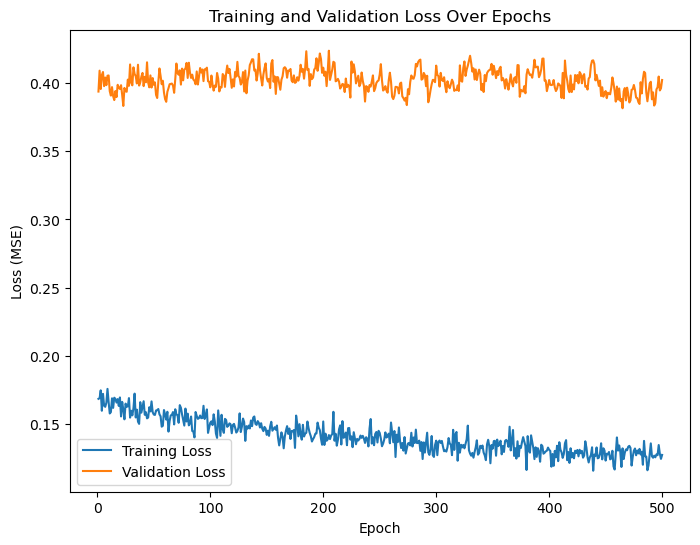

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), training_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), validation_losses, label="Validation Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

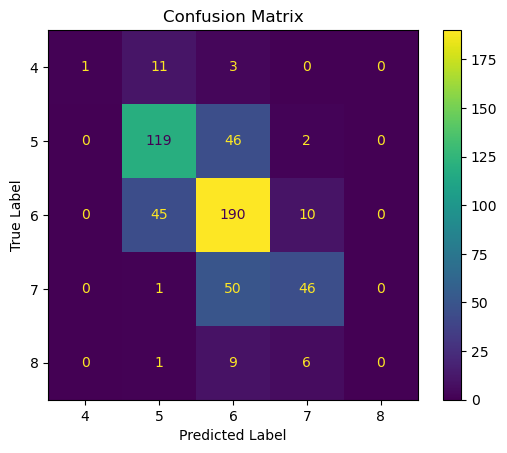

In [25]:
bins = [0, 4.5, 5.5, 6.5, 7.5, 10]
labels = [4, 5, 6, 7, 8]

y_pred_classes = pd.cut(y_pred_list, bins=bins, labels=labels).astype(int)
y_true_classes = pd.cut(y_true_list, bins=bins, labels=labels).astype(int)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap="viridis")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()